In [2]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

regenerate = False

pb.ion()

file_base = ""
emu_vlabel = "G7a"

In [3]:
X_raw = np.load("hc_G6_pred_r1.npy", allow_pickle=True)
Y_raw = np.load("samples_G6_pred_r1.npy", allow_pickle=True)

In [4]:
scales = np.load("../standard_k.npy", allow_pickle=True)

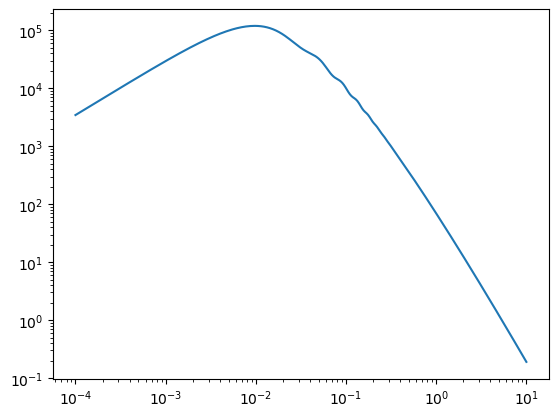

In [5]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.loglog(scales, Y_raw[0])

In [6]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [7]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
ymu = np.mean(Ylog, axis=0)
ymu.shape
ystdev = np.std(Ylog, axis=0)
ystdev.shape

(300,)

In [8]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= ymu
    Y_normalized[i] /= ystdev

In [9]:
# Now the goal is to compute summary statistics on X
#Xlog = np.log(X)
xmu = np.mean(X, axis=0)
xmu.shape
xstdev = np.std(X, axis=0)
xstdev.shape

(6,)

In [10]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)

In [11]:
par_ranges

{'om_b': [0.0205, 0.02415],
 'om_c': [0.085, 0.155],
 'n_s': [0.92, 1.01],
 'sigma12': [0.2, 1],
 'A_s': [1.15e-09, 4.989895197340787e-09],
 'om_nu': [0.0, 0.01]}

In [12]:
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])
    
print(xmin)
print(xrange)

[2.05e-02 8.50e-02 9.20e-01 2.00e-01 1.15e-09 0.00e+00]
[3.6500000e-03 7.0000000e-02 9.0000000e-02 8.0000000e-01 3.8398952e-09
 1.0000000e-02]


In [13]:
# now normalize the data with these summary statistics
X_normalized = cp.deepcopy(X)

'''
for i in range(len(X)):
    X_normalized[i] -= xmu
    X_normalized[i] /= xstdev
'''

for i in range(len(X)):
    X_normalized[i] -= xmin
    X_normalized[i] /= xrange

In [42]:
print(X_normalized)

[[0.7069     0.3481     0.2945     0.96489775 0.4487     0.8207    ]
 [0.0395     0.1013     0.7117     0.82810014 0.9219     0.1683    ]
 [0.3433     0.4039     0.1597     0.75490011 0.9935     0.9237    ]
 ...
 [0.5959     0.2261     0.1297     0.0057     0.4195     0.8807    ]
 [0.7477     0.1511     0.0401     0.52950002 0.9245     0.2545    ]
 [0.6575     0.8109     0.2405     0.62670004 0.6169     0.5913    ]]


In [45]:
print(np.min(X_normalized, axis=0))

[1.00000000e-04 1.00000000e-04 1.00000000e-04 9.99999474e-05
 1.00000000e-04 1.00000000e-04]


In [46]:
print(np.max(X_normalized, axis=0))

[0.9999     0.9999     0.9999     0.99990027 0.9999     0.9999    ]


In [47]:
print(np.median(X_normalized, axis=0))

[0.5        0.5        0.5        0.50000012 0.5        0.5       ]


In [48]:
print(np.mean(X_normalized, axis=0))

[0.5        0.5        0.5        0.49999109 0.5        0.5       ]


In [15]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * ystdev + ymu)

In [16]:
def xtransform(configuration):
    return (configuration - xmu) / xstdev

def xtransform2(configuration):
    return (configuration - xmin) / xrange

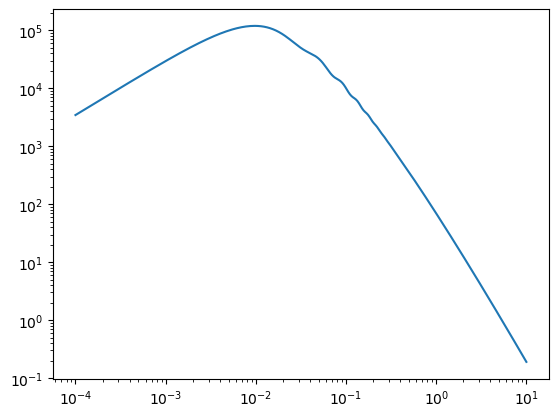

In [17]:
pb.loglog(scales, inverse_ytransform(Y_normalized[0]))

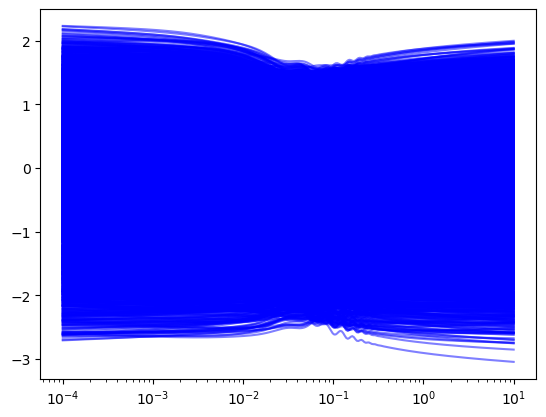

In [18]:
for i in range(len(Y_normalized)):
    pb.plot(scales, Y_normalized[i], alpha=0.5, color='blue')
pb.xscale('log')

In [19]:
print(X_normalized.shape, Y_normalized.shape)

(5000, 6) (5000, 300)


In [20]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X_normalized,Y_normalized,kernel)

In [21]:
test_omnuh2 = 0.002

m0_without_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)
m0_with_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], test_omnuh2, 1)

m0_with_neuts['omch2'] -= test_omnuh2

In [22]:
# We'll need to check our work using CAMB
p_true_interpolator = ci.andrea_interpolator(m0_with_neuts)#,
#    redshifts=[0], kmax=10)
p_m0truth = np.array([p_true_interpolator.P(0, k) for k in scales])

s_m0truth = ci.s12_from_interpolator(p_true_interpolator, 0)

m0_without_neuts['sigma12'] = m0_with_neuts['sigma12'] = s_m0truth

print(s_m0truth)

nnu_massive: 1
0.7864558724216139


In [23]:
p_m0truth2, actual_sigma12, best_z = ged.interpolate_cell(m0_with_neuts, scales)

nnu_massive: 0
nnu_massive: 1


In [24]:
import pickle

if regenerate:
    assert False, "you should give this emulator a new name instead of over-writing"
    m.constrain_positive('') # '' is a regex matching all parameter names
    m.optimize()
    
    m.ymu = ymu
    m.ystdev = ystdev
    m.xmu = xmu
    m.xstdev = xstdev
    pickle.dump(m, open("analyses/massive_emulator_" + emu_vlabel + ".nucomet", "wb"), protocol=5) 
else:
    m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".nucomet", "rb"))

In [25]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    m0_with_neuts['ombh2'], m0_with_neuts['omch2'], m0_with_neuts['n_s'],
    s_m0truth, m0_with_neuts['A_s'], m0_with_neuts['omnuh2']
])])
x

array([[2.24450000e-02, 1.18567000e-01, 9.60000000e-01, 7.86455872e-01,
        2.12723788e-09, 2.00000000e-03]])

In [26]:
guess, uncertainties = m.predict(xtransform2(x))

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

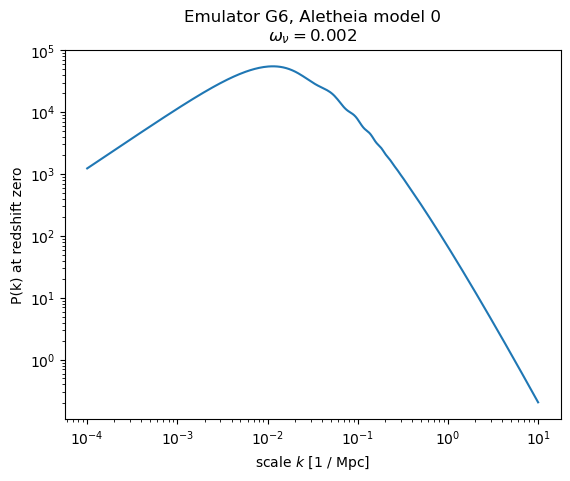

In [27]:
#import matplotlib.pyplot as plt
pb.loglog(scales, inverse_ytransform(guess[0]))
pb.title("Emulator G6, Aletheia model 0\n" + r"$\omega_\nu=0.002$")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

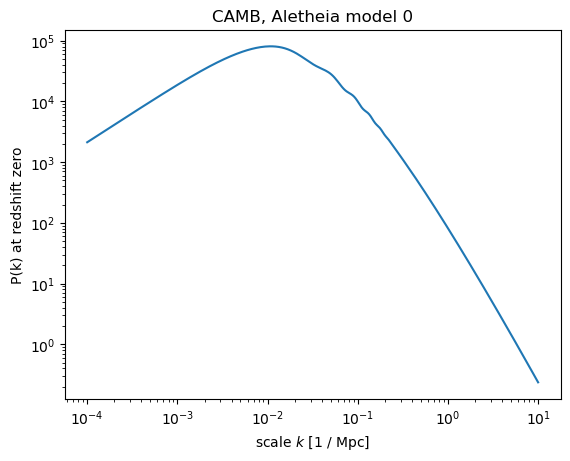

In [28]:
#import matplotlib.pyplot as plt
pb.loglog(scales, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

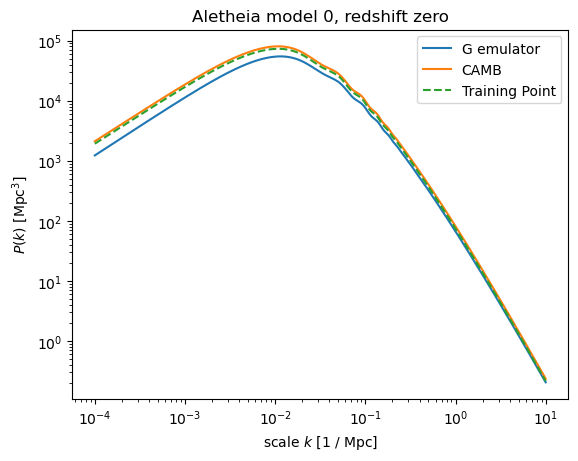

In [29]:
pb.plot(scales, inverse_ytransform(guess[0]),
    label="G emulator")
pb.loglog(scales, p_m0truth, label="CAMB")
pb.loglog(scales, p_m0truth2, label="Training Point", linestyle='dashed')
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

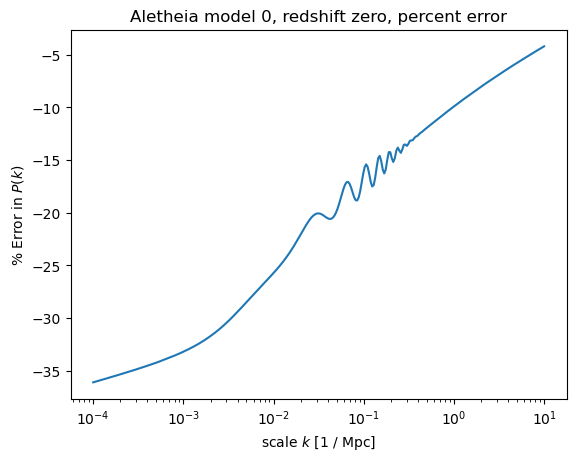

In [30]:
pb.plot(scales,
    (inverse_ytransform(guess[0]) - p_m0truth2) / p_m0truth2 * 100)
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

In [31]:
# Remember that the structure of an hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(xtransform2(x_lo_ns))


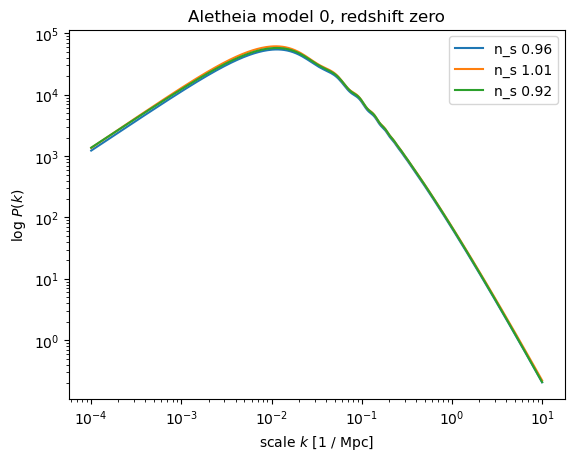

In [32]:
pb.loglog(scales, inverse_ytransform(guess[0]), label="n_s 0.96")
pb.loglog(scales, inverse_ytransform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scales, inverse_ytransform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

In [33]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_hi
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(xtransform2(x_hi_omnu))

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_mid,
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(xtransform2(x_mid_omnu))


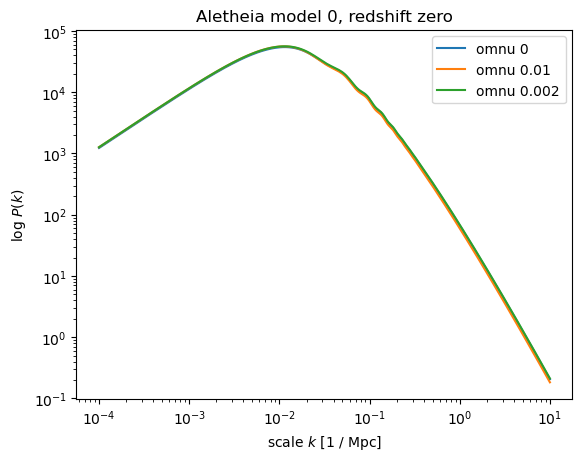

In [34]:
pb.loglog(scales, inverse_ytransform(guess[0]),
          label="omnu 0")
pb.loglog(scales, inverse_ytransform(guess_hi_omnu[0]),
          label="omnu 0.01")
pb.loglog(scales, inverse_ytransform(guess_mid_omnu[0]),
          label="omnu 0.002")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [35]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(xtransform2(x_hi_omb))

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(xtransform2(x_lo_omb))


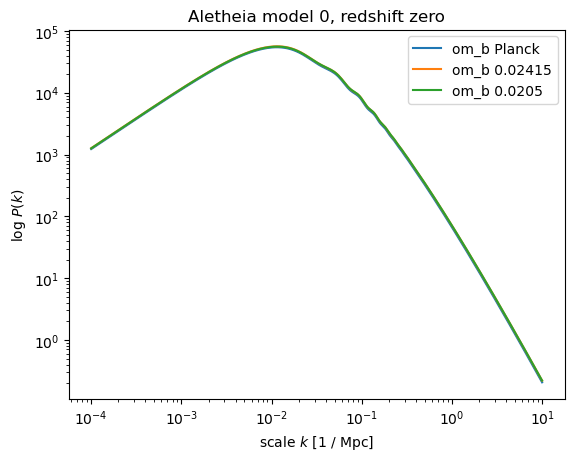

In [36]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_b Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scales, inverse_ytransform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [37]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(xtransform2(x_hi_omc))

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(xtransform2(x_lo_omc))


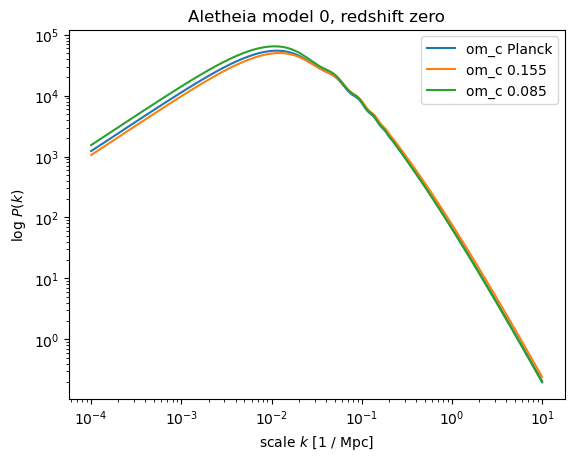

In [38]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_c Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scales, inverse_ytransform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [39]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(3.91) / 10 ** 10, 0
])])
guess_hi_As, uncertainties_hi_As = m.predict(xtransform2(x_hi_As))
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(2.35) / 10 ** 10, 0
])])
guess_lo_As, uncertainties_lo_As = m.predict(xtransform2(x_lo_As))

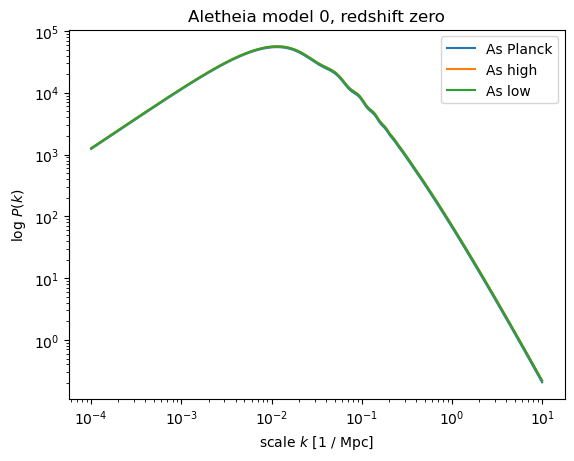

In [40]:
pb.loglog(scales, inverse_ytransform(guess[0]), label="As Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_As[0]), label="As high")
pb.loglog(scales, inverse_ytransform(guess_lo_As[0]), label="As low")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

I guess this shows that sigma12 countermands As, huh?